In [1]:
## importing necessary dependies

import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from obspy.geodetics.base import gps2dist_azimuth

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time
import pygmt
import matplotlib

In [2]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['font.weight'] = 'bold'

In [3]:
iq_lats = pd.read_csv('icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278

no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)

In [4]:
def find_mislabelled_eq_index(station = 'SCM'):
    X = np.loadtxt("tsfel_features/all/1min/"+station+".txt")
    y = np.loadtxt("tsfel_features/all/1min/"+station+"_labels.txt")
    
    s1 = len(X)*(0.8)
    
    X_train = X[0:int(s1)]
    y_train = y[0:int(s1)]
    
    X_test = X[int(s1):]
    y_test = y[int(s1):]
    
    
    trainedforest = RandomForestClassifier(n_estimators=100).fit(X_train,y_train)
    predictionforest = trainedforest.predict(X_test)
    
    arr = np.where(np.array(predictionforest) != np.array(y_test))[0]
    r = np.array(glob('Data/icequake_waveforms/*'+station+'*')
                 +glob('Data/earthquake_waveforms/*'+station+'*'))[arr+int(s1)]
    
    return r

def find_mislabelled_iq_index(station = 'SCM'):
    X = np.loadtxt("tsfel_features/all/1min/"+station+".txt")
    y = np.loadtxt("tsfel_features/all/1min/"+station+"_labels.txt")
    
    s1 = len(X)*(0.2)
    
    X_train = X[int(s1):]
    y_train = y[int(s1):]
    
    X_test = X[0:int(s1)]
    y_test = y[0:int(s1)]
    
    
    trainedforest = RandomForestClassifier(n_estimators=100).fit(X_train,y_train)
    predictionforest = trainedforest.predict(X_test)
    
    
    arr = np.where(np.array(predictionforest) != np.array(y_test))[0]
    r = np.array(glob('Data/icequake_waveforms/*'+station+'*')
                 +glob('Data/earthquake_waveforms/*'+station+'*'))[arr]
    
    return r

In [5]:
find_mislabelled_iq_index()

array(['Data/icequake_waveforms/icequake1020_SCM.mseed',
       'Data/icequake_waveforms/icequake1061_SCM.mseed',
       'Data/icequake_waveforms/icequake1296_SCM.mseed',
       'Data/icequake_waveforms/icequake138_SCM.mseed',
       'Data/icequake_waveforms/icequake1392_SCM.mseed',
       'Data/icequake_waveforms/icequake1396_SCM.mseed',
       'Data/icequake_waveforms/icequake150_SCM.mseed',
       'Data/icequake_waveforms/icequake168_SCM.mseed'],
      dtype='<U51')

In [6]:
r_iq = find_mislabelled_iq_index()

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9

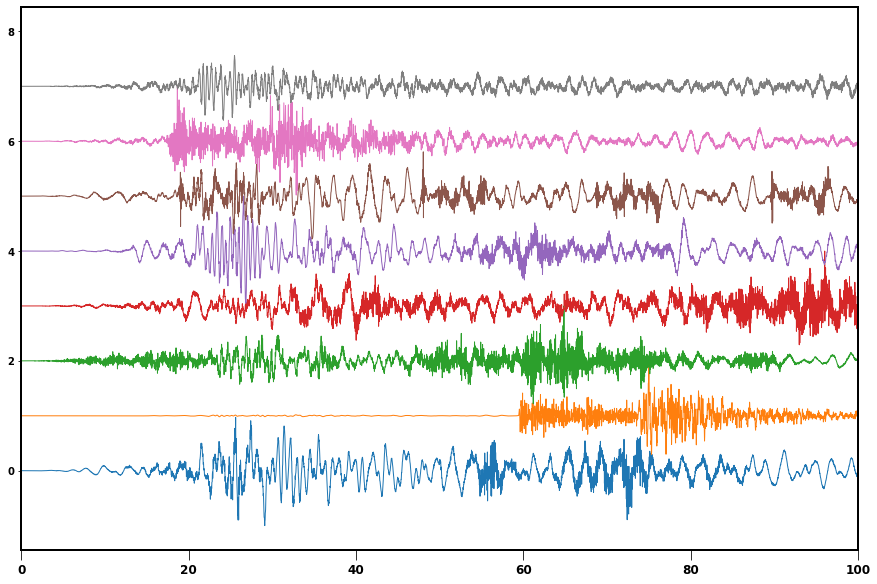

In [7]:
plt.figure(figsize = [15,10])

for i in range(len(r_iq)):
    
    st = obspy.read(r_iq[i])[0]
    st.taper(0.1)
    st.filter('bandpass', freqmin = 0.5, freqmax = 25)
    d = st.data/max(abs(st.data))
    t = st.times()
    
    plt.plot(t, d+i)
    plt.xlim(0,100)
    
plt.show()

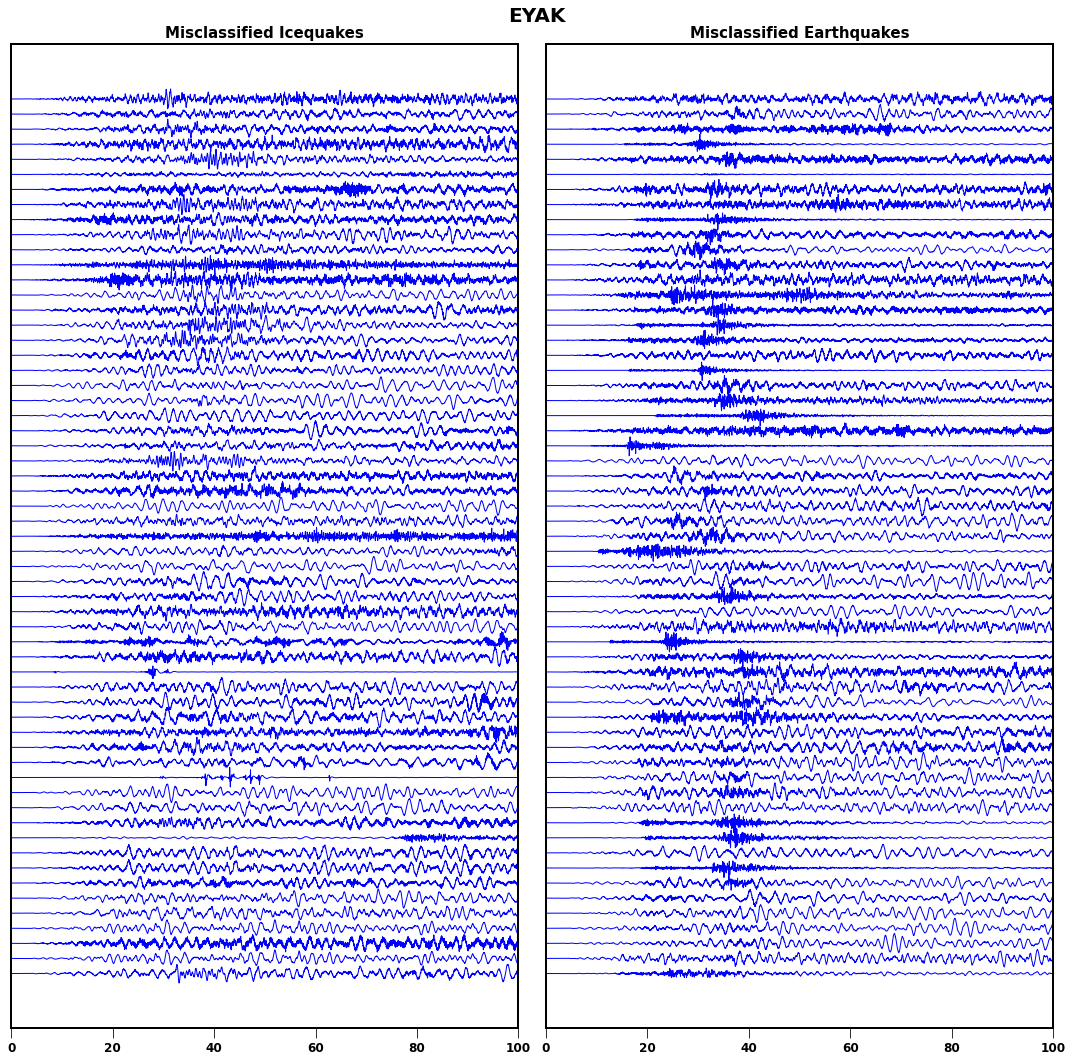

In [8]:
import warnings
warnings.filterwarnings("ignore")
fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(15,15), sharey='row', gridspec_kw=
                                                   { 'width_ratios':[1,1]})


station = 'EYAK'

r_iq = find_mislabelled_iq_index(station)
r_eq = find_mislabelled_eq_index(station)

for i in range(min([len(r_iq),len(r_eq)])):
    
    try:
        st = obspy.read(r_iq[i])[0]
        st.taper(0.1)
        st.filter('bandpass', freqmin = 0.5, freqmax = 25)
        d = st.data/max(abs(st.data))
        t = st.times()

        ax[0].plot(t, d+1.5*i, color='blue', lw = 1)
        ax[0].set_xlim(0,100)
        ax[0].set_yticks([])
        ax[0].set_title('Misclassified Icequakes', fontsize = 15, fontweight = 'bold')
    
    except:
        pass

for i in range(min([len(r_iq),len(r_eq)])):
    
    try:
        st = obspy.read(r_eq[i])[0]
        st.taper(0.1)
        st.filter('bandpass', freqmin = 0.5, freqmax = 25)
        d = st.data/max(abs(st.data))
        t = st.times()

        ax[1].plot(t, d+1.5*i, color='blue', lw = 1)
        ax[1].set_xlim(0,100)
        ax[1].set_title('Misclassified Earthquakes', fontsize = 15, fontweight = 'bold')
    except:
        pass
    
 
fig.suptitle(station, fontsize= 20, fontweight='bold', y=0.98)

fig.tight_layout()

